In [144]:
%load_ext autoreload
%autoreload 2
from utils import *
from IPython.display import display, HTML
import scipy.stats 
ins = BrainSpan()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
# Columns Meta Data
bp_exon_col_meta = pd.read_csv("./brainspan/exon_col_meta.csv")
cds_dict = loaddict()
bp_exon_row_meta = pd.read_csv("./brainspan/rows_metadata.csv")
bp_exon_row_meta["exon length"] = bp_exon_row_meta["end"] - bp_exon_row_meta["start"]
bp_exon_row_meta["cds length"] = bp_exon_row_meta.apply(lambda row: addcds(row, cds_dict), axis=1)
bp_exon_row_meta = MakeExonID(bp_exon_row_meta)
bp_exon_row_meta.head(2)
display(bp_exon_row_meta.head(2))
display(bp_exon_col_meta.head(2))

2400

,row_num,gene_id,ensembl_gene_id,gene_symbol,entrez_id,start,end,exon length,cds length,EXONID2
0,1249,1086943,ENSG00000005108,THSD7A,221981.0,11410063,11415505,5442,82,THSD7A_1
1,1250,1086943,ENSG00000005108,THSD7A,221981.0,11416196,11416284,88,88,THSD7A_2


,Unnamed: 0,column_num,donor_id,donor_name,age,gender,structure_id,structure_acronym,structure_name,Period,Stage,Description
0,0,1,13058,H376.IIA.51,8 pcw,M,10665,URL,upper (rostral) rhombic lip,2A,2,Early prenatal
1,1,2,13058,H376.IIA.51,8 pcw,M,10194,OFC,orbital frontal cortex,2A,2,Early prenatal


In [9]:
EXON_EXP_RPKM = pd.read_csv("./brainspan/qn.exons_matrix.csv", header=None)
EXON_EXP_RPKM.head(2)

,0,1,2,3,4,5,6,7,8,9,...,515,516,517,518,519,520,521,522,523,524
0,1249,13.981005,8.395309,2.331361,9.548689,13.077358,4.957344,11.519273,8.687774,8.699095,...,1.683465,1.528594,2.038370,3.015371,2.237213,2.333633,3.401376,1.251418,2.433152,4.952924
1,1250,13.693688,4.080420,1.455547,10.199496,11.281002,4.150340,14.074131,10.813428,8.187593,...,0.000000,0.452619,1.078534,1.501325,0.878050,1.277496,0.737068,1.999100,3.102934,0.000000


In [30]:
Stage2Idx = {}
for stage in Stages:
    tmp = bp_exon_col_meta[bp_exon_col_meta["Period"]==stage]
    Stage2Idx[stage]=tmp["column_num"].values

In [153]:
exonid2cds = pd.read_csv("../data/Andy-brainspan/brainspan_exon_cds.tsv", delimiter="\t")
exonid2cds.head(2)
exonid2cds = dict(zip(exonid2cds["exon_id"].values, exonid2cds["cds_len"].values))

In [31]:
ExonID2EXP_mean = GetExonTimeExp(EXON_EXP_RPKM, Stage2Idx)

In [56]:
ExonID2EXP_median = GetExonTimeExp(EXON_EXP_RPKM, Stage2Idx, stat="median")

In [64]:
ExonID2EXP_log2 = GetExonTimeExp(EXON_EXP_RPKM, Stage2Idx, stat="mean", log2=True)

In [80]:
ExonID2EXP_log2_median = GetExonTimeExp(EXON_EXP_RPKM, Stage2Idx, stat="median", log2=True)

In [35]:
VarFile = pd.read_excel("./data/ProLGD_wilger2014_predicted.July20.xlsx",index=False)
VarFile.head(2)

,familyId,location,variant,vcfVariant,inChild,fromParent,effectGene,effectType,familyDescription,ExonID,Gender,VIQ,NVIQ
0,13545,20:49509095,ins(T),20:49509094:G:GT,pM,NaN,ADNP,frame-shift,pM,41150,M,23,38
1,12130,20:49510028,del(2),20:49510027:CTT:C,pF,NaN,ADNP,frame-shift,pF,41150,F,62,55


In [162]:
exonPartition = pd.read_csv("/Users/jiayao/Work/BrainDisorders/data/Andy-brainspan/PartitionExons_v2_byq.csv")

AndyGeneSet = set([x.split("_")[0] for x in exonPartition["exon_id"].values])
ExonID2Part = dict(zip(exonPartition["exon_id"].values, exonPartition["group_id"].values))
#PredictedLGDGeneSet.difference(AndyGeneSet)
#AndyGeneSet.difference(PredictedLGDGeneSet)
exonPartition.head(2)
Exon_Coord = pd.read_csv("../data/Andy-brainspan/BrainSpan_RNAseq_Gencode_Exon_Coordinates.flat", 
    delimiter="\t")
Exon_Coord.head(2)
Exon_Coord["length"] = Exon_Coord["end_post"] - Exon_Coord["start_post"]
ExonID2Length = dict(zip(Exon_Coord["exon_id"].values, Exon_Coord["length"].values))
ExonID2Length = exonid2cds

In [177]:
Genes = list(AndyGeneSet)
expdict_gene = {}
ExonPool = PoolTheExons2(ins, ExonID2EXP_mean, VarFile, Genes, bp_exon_row_meta, exonid2cds,
                       minLog2RPKMplus1Cut = 1)

In [234]:
#ExonID2EXP_median
ExonPool2 = PoolTheExons2(ins, ExonID2EXP_median, VarFile, Genes, bp_exon_row_meta, ExonID2Length,
                       minLog2RPKMplus1Cut = 1)

/Users/jiayao/Work/BrainDisorders/src/utils.py:3300: RuntimeWarning: invalid value encountered in double_scalars
  self.relbias = np.mean(self.exonExp[:6]) / np.mean(self.exonExp[6:])
/Users/jiayao/Work/BrainDisorders/src/utils.py:3300: RuntimeWarning: divide by zero encountered in double_scalars
  self.relbias = np.mean(self.exonExp[:6]) / np.mean(self.exonExp[6:])


In [228]:
#ExonID2EXP_log2
ExonPool3 = PoolTheExons2(ins, ExonID2EXP_log2, VarFile, Genes, bp_exon_row_meta, ExonID2Length,
                       minLog2RPKMplus1Cut = 1)

In [221]:
#ExonID2EXP_log2_median
ExonPool4 = PoolTheExons2(ins, ExonID2EXP_log2_median, VarFile, Genes, bp_exon_row_meta, ExonID2Length,
                       minLog2RPKMplus1Cut = 1)

In [240]:
BinsAndy = BinExon_UseAndyBin(ExonPool3, ExonID2Part)
BinsJW = BinExon(ExonPool3)

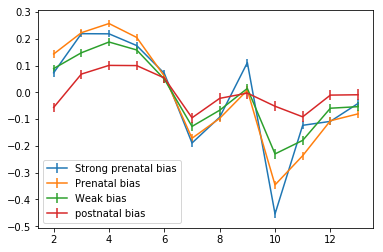

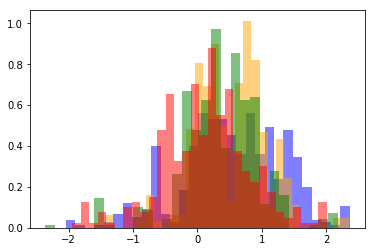

In [241]:
PlotExonBins(BinsAndy)
PlotExonHist(BinsAndy)

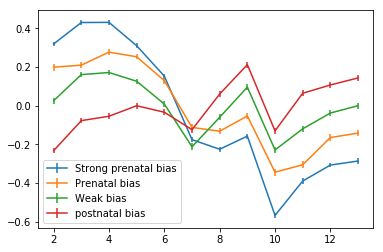

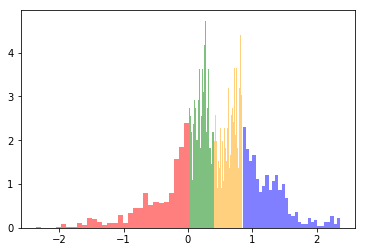

440
440
440
441


In [242]:
PlotExonBins(BinsJW)
PlotExonHist(BinsJW)
for XX in BinsJW:
    print(len(XX))

36 96143
19 77731
26 88341
36 98604


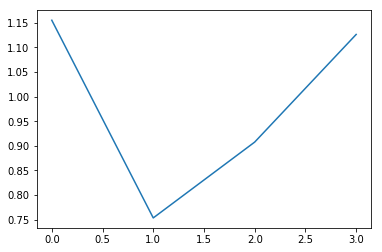

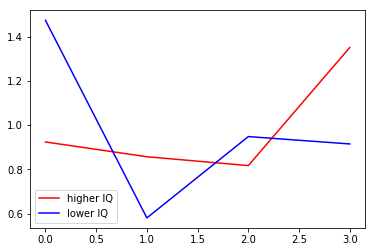

In [243]:
ExonBinsBurden(BinsAndy)

35 81072
29 105189
24 83556
29 91002


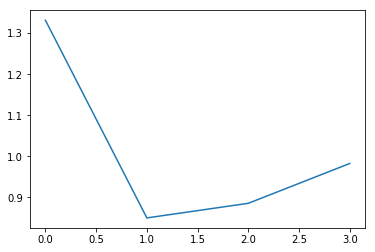

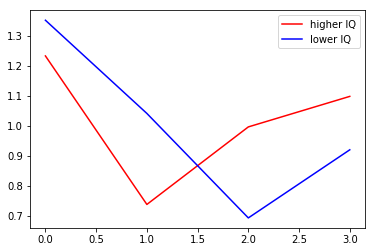

In [244]:
ExonBinsBurden(BinsJW)